In [33]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [34]:
path = 's3fd_filtered-20220501-151030'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [35]:
df_meta

,Python,CPU,GPUs
0,3.8.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [36]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-05-01 15:10:30.543505,8.2,5639442432
1,2022-05-01 15:10:41.569005,61.6,5152813056
2,2022-05-01 15:10:53.979004,58.0,5146443776
3,2022-05-01 15:11:06.491504,64.4,5169168384
4,2022-05-01 15:11:20.232006,61.6,5129392128
...,...,...,...
773,2022-05-01 17:55:16.930182,55.4,6778273792
774,2022-05-01 17:55:29.566183,55.1,6800424960
775,2022-05-01 17:55:41.407182,46.7,6820368384
776,2022-05-01 17:55:53.347682,55.8,6824079360


In [37]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

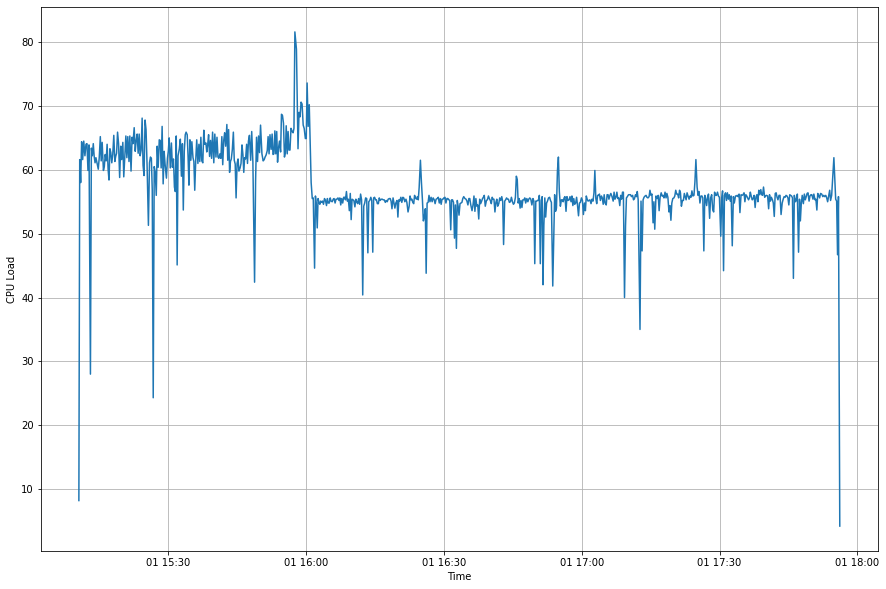

In [38]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

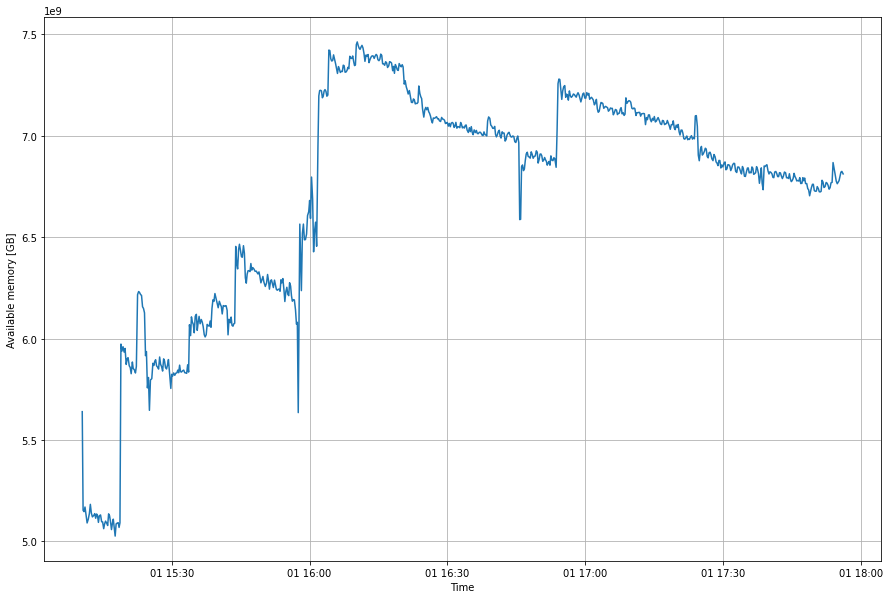

In [39]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

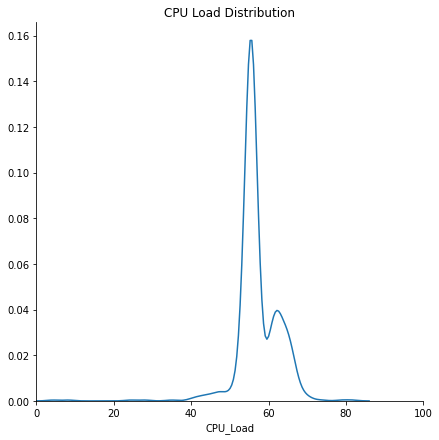

In [40]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

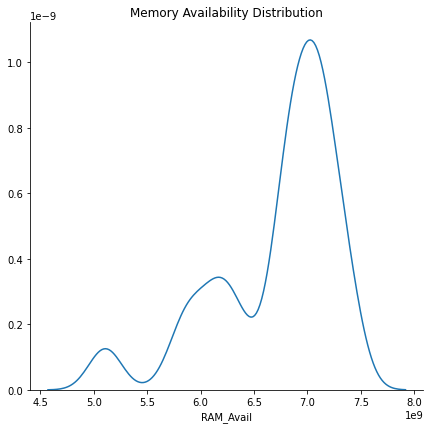

In [41]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [42]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-05-01 15:10:33.946505,2775709300,1.0,1.0,1.0,"[0.9082491582491582, 0.9106326219512195, 0.923...",8,0,0,8,"[(909.0, 330.0, 975.0, 420.0), (717.0, 229.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-05-01 15:10:39.089004,5135724400,1.0,1.0,1.0,[0.8413917758698599],1,0,0,1,"[(555.0, 1231.0, 695.0, 1329.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-05-01 15:10:41.568504,2471205400,1.0,1.0,1.0,[0.7413652434049497],1,0,0,2,"[(557.0, 115.0, 604.0, 174.0), (458.0, 46.0, 4...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-05-01 15:10:45.263505,3558202900,0.0,0.0,0.0,[],0,0,0,62,"[(256.0, 496.0, 290.0, 540.0), (288.0, 431.0, ...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-05-01 15:10:47.484007,2196882800,1.0,1.0,1.0,"[0.8683905827865689, 0.9119380987472365, 0.731...",7,0,0,8,"[(201.0, 76.0, 248.0, 129.0), (272.0, 70.0, 31...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-05-01 17:55:48.510682,4824235100,1.0,1.0,1.0,[0.8202566140570001],1,0,0,1,"[(458.0, 159.0, 594.0, 327.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-05-01 17:55:53.347682,4827148000,1.0,1.0,1.0,"[0.8058540200074101, 0.7615869484612533]",2,0,0,2,"[(715.0, 420.0, 797.0, 536.0), (330.0, 416.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-05-01 17:55:56.175683,2697513300,0.0,0.0,0.0,[],0,0,0,27,"[(678.0, 490.0, 709.0, 526.0), (69.0, 307.0, 1...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-05-01 17:55:58.148182,1946609500,1.0,1.0,1.0,"[0.9076054664289959, 0.7877862595419848]",2,0,0,7,"[(854.0, 78.0, 901.0, 143.0), (753.0, 64.0, 78...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [43]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,3.015798e+09,0.721761,0.699838,0.700848,1.907006,0.074086,0.302232,12.308741
std,1.126726e+09,0.433577,0.429566,0.423561,2.615760,0.320510,0.951592,39.822258
min,8.200083e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.310268e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.562495e+09,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000
75%,3.422770e+09,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,9.000000
max,2.030265e+10,1.000000,1.000000,1.000000,31.000000,7.000000,20.000000,709.000000


In [44]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,4445.960400,True,True,True
1,3493.232000,True,True,True
2,2566.523700,True,True,False
3,2562.509000,True,True,False
4,2475.888200,True,True,True
...,...,...,...,...
6386,40.165420,True,True,True
6387,38.866726,False,False,False
6388,36.745995,False,False,False
6389,31.007717,False,False,False


In [45]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [46]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,4445.960400,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,3493.232000,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,2566.523700,True,True,False,1.000000,0.000421,1.000000,0.000421,0.666667,0.000281
3,2562.509000,True,True,False,1.000000,0.000561,1.000000,0.000561,0.500000,0.000281
4,2475.888200,True,True,True,1.000000,0.000702,1.000000,0.000702,0.600000,0.000421
...,...,...,...,...,...,...,...,...,...,...
6386,40.165420,True,True,True,0.963833,0.863758,0.954595,0.855479,0.788790,0.706889
6387,38.866726,False,False,False,0.963682,0.863758,0.954446,0.855479,0.788666,0.706889
6388,36.745995,False,False,False,0.963531,0.863758,0.954296,0.855479,0.788543,0.706889
6389,31.007717,False,False,False,0.963380,0.863758,0.954147,0.855479,0.788419,0.706889


In [47]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

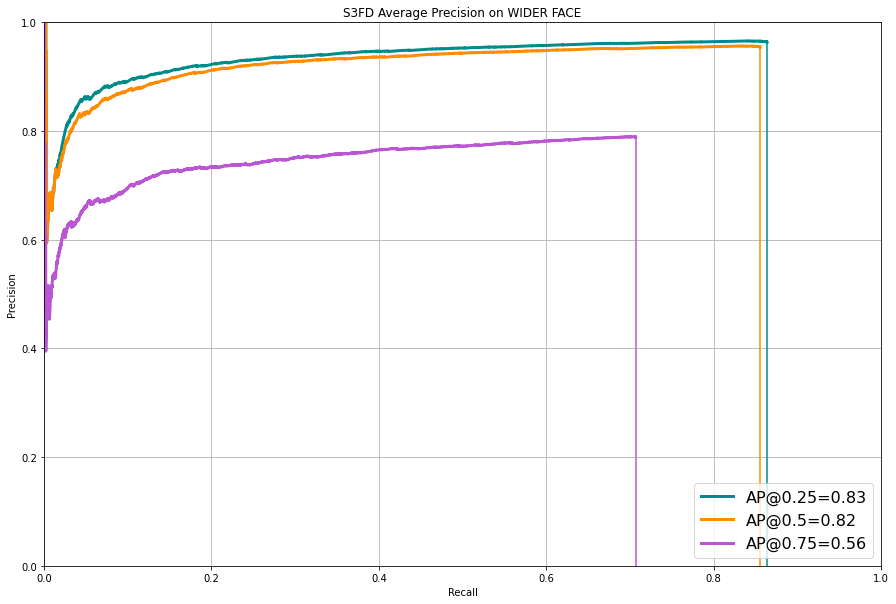

In [48]:
plot_pr(df_ap, 'S3FD Average Precision on WIDER FACE')